# DistilBERT Fine-Tuning with PyTorch

This notebook is an example of how to fine-tune a DistilBERT model using PyTorch and the Hugging Face Transformers library to perform sentiment analysis on the amazon reviews dataset. The dataset is available [here](https://www.kaggle.com/datasets/tarkkaanko/amazon).

This version of the notebook uses the balanced training dataset, which contains a balanced number of 1,2,3,4 and 5 star reviews. The dataset is split into 55% training, 25% validation and 20% testing.

This results are discussed in the report.

In [8]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score
from matplotlib import pyplot as plt 

In [9]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Assicurati che le etichette siano interi e non one-hot, e sono scalari per ogni esempio.
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)  # dtype=torch.long per etichette di classificazione
        return item

class DistilBertModelBuilder:
    def __init__(self, num_labels, max_length=512):
        # Il tokenizer è definito come attributo della classe qui
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
        self.max_length = max_length
        self.trainer = None

    def train(self, X_train, y_train, X_val, y_val, epochs=3, batch_size=8):
        # Utilizzo del tokenizer definito nell'oggetto
        train_dataset = SentimentDataset(X_train, y_train, self.tokenizer, self.max_length)
        val_dataset = SentimentDataset(X_val, y_val, self.tokenizer, self.max_length)
        
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
        )

        self.trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset
        )

        self.trainer.train()

    def predict(self, X_test, y_test):
        test_dataset = SentimentDataset(X_test, y_test, self.tokenizer, self.max_length)
        predictions = self.trainer.predict(test_dataset)
        print(f"Predictions shape: {predictions.predictions.shape}")  # Dimensioni dell'output del modello
        print(f"Label shape: {predictions.label_ids.shape}")  # Dimensioni delle etichette
        y_pred = np.argmax(predictions.predictions, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f'F1 score: {f1:.2f}')
        print(f'Accuracy: {accuracy:.2f}')
        print(classification_report(y_test, y_pred)) 
        return y_pred

    def get_model(self):
        return self.model

In [11]:
# Gestione dei dati non bilanciati per confronto
from data import DataPreprocessor
unbalanced_data = DataPreprocessor('amazon_reviews.csv')
unbalanced_data.load_and_preprocess()
unbalanced_data.split_data()

X_train, X_val, X_test, y_train, y_val, y_test = unbalanced_data.get_train_val_test_data()


y_train = [int(label-1) for label in y_train]
y_val = [int(label-1) for label in y_val]
y_test = [int(label-1) for label in y_test]

X_train = [str(text) for text in X_train]
X_val = [str(text) for text in X_val]
X_test = [str(text) for text in X_test]

Data preprocessed successfully!
Preprocessing completed.
Data split completed.


In [12]:
model = DistilBertModelBuilder(num_labels=5)
model.train(X_train, y_train, X_val, y_val, epochs=3, batch_size=8)

/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,1.612400
20,1.599300
30,1.531300
40,1.426900
50,1.274200
60,1.033400
70,0.929600
80,0.762500
90,0.682200
100,0.775200


/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


X_test type: <class 'list'>, shape: (1229,)
y_test type: <class 'list'>, shape: (1229,)


Predictions shape: (1229, 5)
Label shape: (1229,)
F1 score: 0.76
Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.37      0.85      0.52        61
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        35
           3       0.23      0.08      0.11       132
           4       0.88      0.94      0.91       981

    accuracy                           0.80      1229
   macro avg       0.30      0.37      0.31      1229
weighted avg       0.74      0.80      0.76      1229



/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/g.criscione2/Star_predictor/HLT_project/hltenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

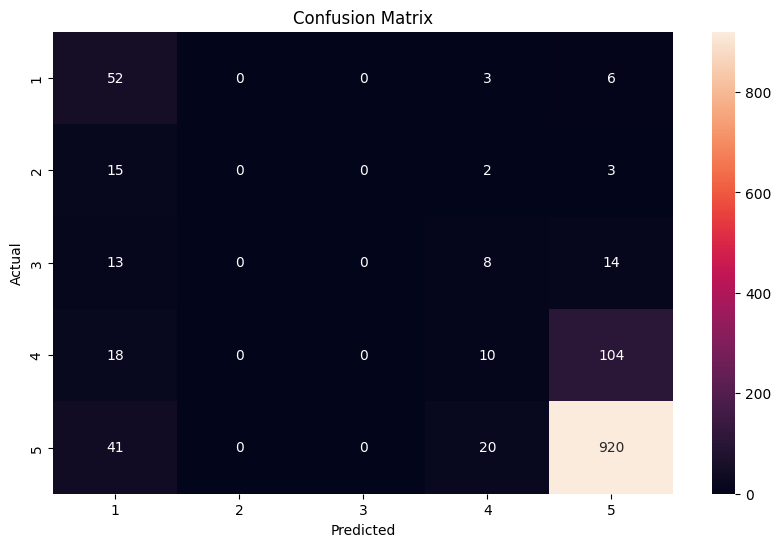

In [14]:
def plot_cm_distilbert(model, X_test, y_test):
    """Plots the confusion matrix for the distilBERT model."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Debugging: Print input shapes and types
    print(f"X_test type: {type(X_test)}, shape: {np.shape(X_test)}")
    print(f"y_test type: {type(y_test)}, shape: {np.shape(y_test)}")
    
    # Call the predict function
    y_pred = model.predict(X_test, y_test)
    
    # Debugging: Print the output of the predict function
    #print(f"y_pred: {y_pred}")

    # Check if y_pred is None
    if y_pred is None:
        raise ValueError("model.predict returned None")

    #y_pred = [np.argmax(pred) for pred in y_pred]
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=[i for i in range(1, 6)], columns=[i for i in range(1, 6)])
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example usage:
plot_cm_distilbert(model, X_test, y_test)

#plot_cm_distilbert(model, X_test_balanced, y_test_balanced)
